In [6]:
!touch ~/.kaggle/kaggle.json

In [8]:
api_token = {"username":"innakivachuk","key":"..."}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [04:41<00:00, 36.1MB/s]
100% 28.6G/28.6G [04:41<00:00, 109MB/s] 


In [10]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import binary_opening, disk, label
from skimage.io import imread

In [ ]:
! unzip ./airbus-ship-detection.zip -d ./data/

In [15]:
# uploading data
ship_data = pd.read_csv('data/train_ship_segmentations_v2.csv')
has_masks = ship_data['EncodedPixels'].notna()
print(f'There is {has_masks.sum()} masks in {ship_data.shape[0]} photos')

There is 81723 masks in 231723 photos


In [16]:
# Function to determine the presence of ships in 'EncodedPixels'
def has_ship(encoded_pixels):
    return 1 if isinstance(encoded_pixels, str) else 0

# Create a new column 'ships' indicating the presence of ships
ship_data['ships'] = ship_data['EncodedPixels'].apply(has_ship)

# Group by 'ImageId' and calculate the sum of 'ships' for each image
ship_counts_per_image = ship_data.groupby('ImageId')['ships'].sum().reset_index()

# Create a new column 'has_ship' indicating whether there is at least one ship in the image
ship_counts_per_image['has_ship'] = ship_counts_per_image['ships'].apply(lambda x: 1.0 if x > 0 else 0.0)

# Drop the 'ships' column from the masks DataFrame
ship_data = ship_data.drop(columns = ['ships'])

ship_counts_per_image.head()

,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0


In [17]:
# Set the desired number of ships for balancing
TARGET_SHIPS = 4000

# Split the data into two groups: with ships and without ships
with_ships = ship_counts_per_image[ship_counts_per_image['has_ship'] == 1]
without_ships = ship_counts_per_image[ship_counts_per_image['has_ship'] == 0]

# Choose a random subset without ships with a size equal to TARGET_SHIPS
balanced_without_ships = without_ships.sample(n=TARGET_SHIPS, random_state=42)

# Combine both groups to get a balanced DataFrame
balanced_ship_counts_per_image = pd.concat([with_ships, balanced_without_ships])

# Display the first rows of the balanced DataFrame
print(balanced_ship_counts_per_image.head())

         ImageId  ships  has_ship
2  000155de5.jpg      1       1.0
3  000194a2d.jpg      5       1.0
5  00021ddc3.jpg      9       1.0
6  0002756f7.jpg      2       1.0
9  00031f145.jpg      1       1.0


In [18]:
from sklearn.model_selection import train_test_split
# Set the desired percentage of validation data
VALIDATION_SPLIT = 0.25

# Split the balanced DataFrame into training and validation sets
train_balanced_df, valid_balanced_df = train_test_split(balanced_ship_counts_per_image,
                                                       test_size=VALIDATION_SPLIT,
                                                       stratify=balanced_ship_counts_per_image['has_ship'])

# Merge with the original ship_data to obtain final training and validation datasets
train_df = pd.merge(ship_data, train_balanced_df, on='ImageId')
valid_df = pd.merge(ship_data, valid_balanced_df, on='ImageId')

In [19]:
# Batch size
BATCH_SIZE = 32

# Path to the training directory
TRAIN_DIR = 'data/train_v2'

# Image scaling factor
IMG_SCALING = (3, 3)

In [20]:
import os

def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode RLE-encoded mask into a binary image.

    Parameters:
        - mask_rle: RLE-encoded mask as a string
        - shape: Size of the output image in the format (height, width)

    Returns:
        - Binary image (0 for background, 1 for mask region)
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask_string_to_image(mask_string, shape=(768, 768)):
    """
    Convert a single mask string to a binary mask image.

    Parameters:
        - mask_string: RLE-encoded mask string
        - shape: (height, width) of the output mask image

    Returns:
        - Binary mask image
    """
    if isinstance(mask_string, str):
        return rle_decode(mask_string, shape)
    else:
        return np.zeros(shape, dtype=np.uint8)

def masks_as_image(in_mask_list):
    """
    Convert a list of mask strings to a single binary mask image.

    Parameters:
        - in_mask_list: List of RLE-encoded mask strings

    Returns:
        - Binary mask image
    """
    all_masks = np.zeros((768, 768), dtype=np.uint8)
    for mask in in_mask_list:
        all_masks |= mask_string_to_image(mask)
    return all_masks


def make_image_gen(input_df, batch_size=BATCH_SIZE):
    """
    Generate batches of images and masks from a DataFrame.

    Parameters:
        - input_df: DataFrame containing image and mask information
        - batch_size: Number of samples per batch

    Yields:
        - Tuple of batches containing images and corresponding masks
    """
    all_batches = list(input_df.groupby('ImageId'))
    batch_images = []
    batch_masks = []
    while True:
        np.random.shuffle(all_batches)
        for img_id, mask_group in all_batches:
            img_path = os.path.join(TRAIN_DIR, img_id)
            current_image = imread(img_path)

            # Create binary masks from 'EncodedPixels'
            current_mask = np.expand_dims(masks_as_image(mask_group['EncodedPixels'].values), -1)

            # Optionally scale images and masks
            if IMG_SCALING is not None:
                current_image = current_image[::IMG_SCALING[0], ::IMG_SCALING[1]]
                current_mask = current_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]

            batch_images.append(current_image)
            batch_masks.append(current_mask)

            if len(batch_images) >= batch_size:
                # Yield a batch of images and masks
                yield np.stack(batch_images, 0) / 255.0, np.stack(batch_masks, 0).astype(np.float32)
                batch_images, batch_masks = [], []

# Create a training data generator
train_generator = make_image_gen(train_df)

# Get a batch of training data
train_images, train_masks = next(train_generator)

# Display the shape and range of values for the batch
print('Images:', train_images.shape, 'Range:', train_images.min(), '-', train_images.max())
print('Masks:', train_masks.shape, 'Range:', train_masks.min(), '-', train_masks.max())

Images: (32, 256, 256, 3) Range: 0.0 - 1.0
Masks: (32, 256, 256, 1) Range: 0.0 - 1.0


In [21]:
# Set the number of samples for validation
validation_samples = 900

# Create a validation data generator
validation_generator = make_image_gen(valid_df, batch_size=validation_samples)

# Get a batch of validation data
valid_x, valid_y = next(validation_generator)

# Display the shape of validation data
print('Validation Images:', valid_x.shape)
print('Validation Masks:', valid_y.shape)

Validation Images: (900, 256, 256, 3)
Validation Masks: (900, 256, 256, 1)


In [22]:
from keras.preprocessing.image import ImageDataGenerator

def get_image_data_generator(augment_brightness):
    dg_args = dict(
        featurewise_center=False,
        samplewise_center=False,
        rotation_range=45,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.01,
        zoom_range=[0.9, 1.25],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        data_format='channels_last'
    )

    # Include brightness augmentation if specified
    if augment_brightness:
        dg_args['brightness_range'] = [0.5, 1.5]

    return ImageDataGenerator(**dg_args)

def create_augmented_generator(image_gen, label_gen, in_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))

        g_x = image_gen.flow(in_x, batch_size=in_x.shape[0], seed=seed, shuffle=True)
        g_y = label_gen.flow(in_y, batch_size=in_x.shape[0], seed=seed, shuffle=True)

        yield next(g_x), next(g_y)

# Set the AUGMENT_BRIGHTNESS variable based on your requirements
AUGMENT_BRIGHTNESS = True

# Create image and label data generators
image_data_gen = get_image_data_generator(AUGMENT_BRIGHTNESS)
label_data_gen = get_image_data_generator(AUGMENT_BRIGHTNESS)

# Create an augmented data generator
augmented_generator = create_augmented_generator(
    image_data_gen, label_data_gen, make_image_gen(train_df), seed=42
)

# Example usage
augmented_images, augmented_masks = next(augmented_generator)
print('Augmented Images:', augmented_images.shape)
print('Augmented Masks:', augmented_masks.shape)

Augmented Images: (32, 256, 256, 3)
Augmented Masks: (32, 256, 256, 1)


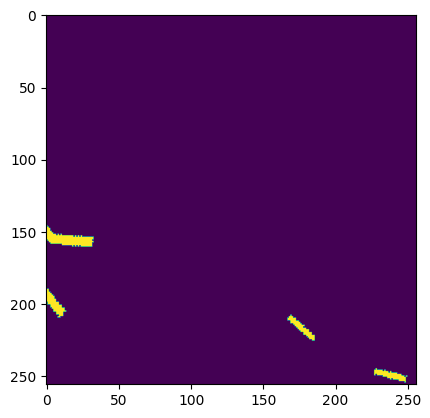

In [27]:
plt.imshow(augmented_masks[1])

In [30]:
from keras import models, layers

MODE = 'SIMPLE'
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if MODE == 'DECONV':
    upsample = upsample_conv
else:
    upsample = upsample_simple

def unet(pretrained_weights=None, input_size=(256, 256, 3), NET_SCALING=(1, 1)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = upsample(8, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    seg_model = models.Model(inputs=[inputs], outputs=[d])

    if pretrained_weights:
        seg_model.load_weights(pretrained_weights)

    return seg_model

# Example usage
seg_model = unet()
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 8)          0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          584       ['dropout[0][0]']             
                                                                                              

In [34]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

ALPHA = 0.8
GAMMA = 2

def focal_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    bce = K.binary_crossentropy(targets, inputs)
    bce_exp = K.exp(-bce)
    focal_loss = K.mean(alpha * K.pow((1 - bce_exp), gamma) * bce)

    return focal_loss

def dice_bce_loss(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    bce =  binary_crossentropy(targets, inputs)
    intersection = K.dot(K.transpose(targets), inputs)
    dice_loss = 1 - (2 * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    dice_bce = bce + dice_loss

    return dice_bce

def dice_p_bce(in_gt, in_pred):
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def dice_loss(targets, inputs, smooth=1e-6):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    dice = (2 * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2 * intersection + smooth) / (union + smooth), axis=0)
    return dice


In [40]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def get_checkpoint_callback(model_name):
    weight_path = f"model_weights/{model_name}_weights.hdf5"
    checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                                 mode='max', save_weights_only=True)
    return checkpoint

def get_reduce_lr_callback():
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2,
                                       patience=3,
                                       verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
    return reduceLROnPlat

def get_early_stopping_callback():
    early = EarlyStopping(monitor="val_dice_coef",
                          mode="max",
                          patience=15)
    return early

def get_callbacks(model_name):
    checkpoint = get_checkpoint_callback(model_name)
    reduce_lr = get_reduce_lr_callback()
    early_stopping = get_early_stopping_callback()

    callbacks_list = [checkpoint, early_stopping, reduce_lr]
    return callbacks_list

# Example usage
model_name = 'seg_model'
callbacks = get_callbacks(model_name)

In [41]:
import tensorflow as tf
def compile_model(model):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=1e-6)
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=focal_loss, metrics=[dice_coef])

def train_model(model, train_generator, validation_data, callbacks_list, max_train_steps, max_train_epochs):
    step_count = min(max_train_steps, train_df.shape[0] // BATCH_SIZE)
    loss_history = [model.fit(train_generator,
                              steps_per_epoch=step_count,
                              epochs=max_train_epochs,
                              validation_data=validation_data,
                              callbacks=callbacks_list,
                              workers=1)]
    return loss_history

def main_training_loop(model, train_generator, valid_x, valid_y, callbacks_list, max_train_steps, max_train_epochs):
    epoch = 0
    while True:
        loss_history = train_model(model, train_generator, (valid_x, valid_y), callbacks_list, max_train_steps, max_train_epochs)
        epoch += max_train_epochs

# Example usage
compile_model(seg_model)
main_training_loop(seg_model, make_image_gen(train_df), valid_x, valid_y, callbacks, 10, 99)


Epoch 1/99
10/10 [==============================] - ETA: 0s - loss: 0.0175 - dice_coef: 0.0064 
Epoch 1: saving model to model_weights/seg_model_weights.hdf5
10/10 [==============================] - 189s 19s/step - loss: 0.0175 - dice_coef: 0.0064 - val_loss: 0.0104 - val_dice_coef: 0.0086 - lr: 9.8764e-04
Epoch 2/99
10/10 [==============================] - ETA: 0s - loss: 0.0095 - dice_coef: 0.0097 
Epoch 2: saving model to model_weights/seg_model_weights.hdf5
10/10 [==============================] - 169s 18s/step - loss: 0.0095 - dice_coef: 0.0097 - val_loss: 0.0103 - val_dice_coef: 0.0126 - lr: 9.7409e-04
Epoch 3/99
10/10 [==============================] - ETA: 0s - loss: 0.0080 - dice_coef: 0.0162 
Epoch 3: saving model to model_weights/seg_model_weights.hdf5
10/10 [==============================] - 185s 20s/step - loss: 0.0080 - dice_coef: 0.0162 - val_loss: 0.0092 - val_dice_coef: 0.0173 - lr: 9.6073e-04
Epoch 4/99
10/10 [==============================] - ETA: 0s - loss: 0.0063 -

KeyboardInterrupt: ignored

In [42]:
seg_model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
import tensorflow as tf
import cv2

def generate_prediction(test_dir, image_name, model, img_scaling=IMG_SCALING):
    # Construct the full path to the image
    image_path = os.path.join(test_dir, image_name)

    # Read and preprocess the image
    image = preprocess_image(image_path, img_scaling)

    # Make prediction using the model
    prediction = model.predict(image)

    # Post-process the prediction
    prediction = postprocess_prediction(prediction)

    # Return the original image and the prediction
    return cv2.imread(image_path), prediction

def preprocess_image(image_path, img_scaling):
    # Read the image
    image = cv2.imread(image_path)

    # Apply scaling and color conversion
    image = image[::img_scaling[0], ::img_scaling[1]]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize the image
    image = image / 255.0

    # Add batch dimension
    image = tf.expand_dims(image, axis=0)

    return image

def postprocess_prediction(prediction):
    # Squeeze the prediction to remove the batch dimension
    prediction = np.squeeze(prediction, axis=0)

    # Add any post-processing steps here if needed

    return prediction


1/1 [==============================] - 0s 174ms/step


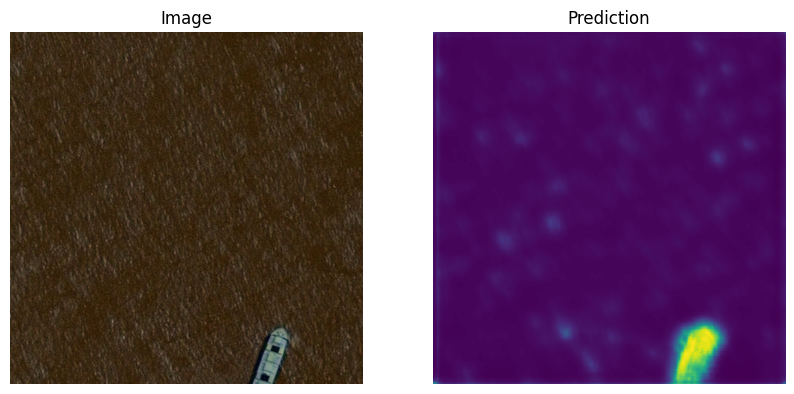

1/1 [==============================] - 0s 170ms/step


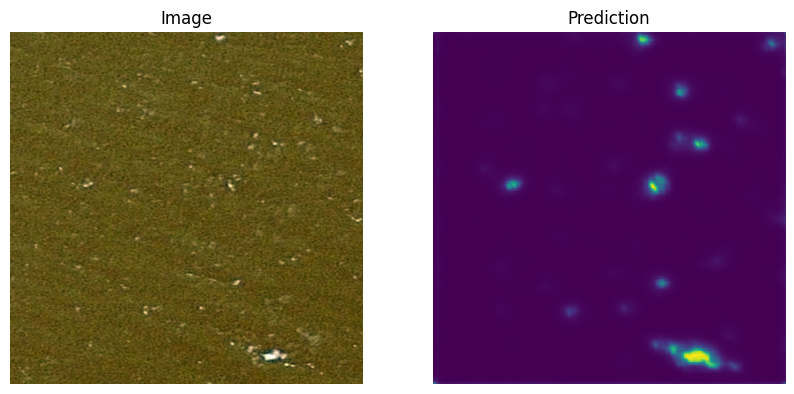

In [47]:
from matplotlib import pyplot as plt

test_imgs = ['002a943bf.jpg', '000bd9dbf.jpg']
%matplotlib inline

def display_image_and_prediction(test_dir, image_name, model):
    img, pred = generate_prediction(test_dir, image_name, model)

    # Plotting the image and prediction side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 7))

    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title("Image")

    axes[1].imshow(pred, interpolation=None)
    axes[1].axis('off')
    axes[1].set_title("Prediction")

    plt.show()

# Display images and predictions
for test_img in test_imgs:
    display_image_and_prediction('data/test_v2', test_img, seg_model)
